In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns




In [2]:
df = pd.read_excel('Human Verification sheet.xlsx')

In [2]:
# Read all sheets from the Excel file
excel_file = pd.ExcelFile('Human Verification sheet.xlsx')
sheet_names = excel_file.sheet_names

# Create a dictionary to store DataFrames for each sheet

cum_df = pd.DataFrame()
# Create a dictionary to store DataFrames for each sheet
sheet_dfs = {}

# Initialize an empty DataFrame to store the combined data
merged_df = pd.DataFrame()

# Define the columns we want to extract and include in our analysis
columns_to_include = [
    'image', 
    'object', 
    'region', 
    'Human Geographic Origin',
    'Urban/Rural',
    'Image Accuracy',
    'Socioeconomic Status',
    'Gender Distribution',
    'Note'
]

# Ensure our cumulative DataFrame has these columns
for col in columns_to_include:
    cum_df[col] = None


# Loop through each sheet and read it into a DataFrame
for sheet in sheet_names:

    if sheet != 'Template':
        obj = sheet 
        df = pd.read_excel(excel_file, sheet_name=sheet)
        cur_region = 'africa'
        # Loop through each row in the DataFrame and print it
        # print(f"\nPrinting rows for sheet: {sheet}")
        for index, row in df.iterrows():
            # print(f"Row {index}: {row.to_dict()}")
            # Print the element in the first column of each row
            first_col_name = df.columns[0]  # Get the name of the first column
            first_col_value = row[first_col_name]  # Get the value in the first column
            # print(f"First column value: {first_col_value}")
            if (not pd.isna(first_col_value)) and first_col_value.lower() in ['africa', 'north america', 'south america', 'europe', 'asia']:
                cur_region = first_col_value

            elif not pd.isna(first_col_value):
                 row = (first_col_value, sheet, cur_region, 
                      row.iloc[1] if len(row) > 1 else None,  # Human Geographic Origin
                      row.iloc[2] if len(row) > 2 else None,  # Human Geographic Origin
                      row.iloc[3] if len(row) > 3 else None,  # Urban/Rural
                      row.iloc[4] if len(row) > 4 else None, 
                      row.iloc[5] if len(row) > 5 else None,  # Image Accuracy
                      row.iloc[6] if len(row) > 6 else None)  # Socioeconomic Status
                 
                 # Create a Series from the row tuple with appropriate column names
                 row_series = pd.Series(row, index=['image', 'object', 'region', 
                                                   'Human Geographic Origin', 'Urban/Rural', 
                                                   'Image Accuracy', 'Socioeconomic Status',  'Gender Distribution', 'Note'])
                 
                 # Append the row to cum_df
                 cum_df = pd.concat([cum_df, row_series.to_frame().T], ignore_index=True)
            
        # Store the DataFrame in the dictionary
        # sheet_dfs[sheet] = df
        
        # print(f"Sheet: {sheet}")
        # print(f"Object: {object_name}")
        # print(f"Region: {region}")
        # print(f"Shape: {sheet_dfs[sheet].shape}")
        # print("First few rows:")
        # print(sheet_dfs[sheet].head())
        # print("\n")


In [18]:
# Capitalize the first letter of each word in the region column
cum_df['region'] = cum_df['region'].str.title()

# Create a new column 'model' based on the image filename
def determine_model(image_name):
    if pd.isna(image_name):
        return None
    image_name = str(image_name).lower()
    if 'dalle' in image_name:
        return 'dalle'
    elif 'kandinsky' in image_name:
        return 'kandinsky'
    elif 'imagen' in image_name:
        return 'imagen'
    elif 'sd_' in image_name:
        return 'sd'
    else:
        return None

# Apply the function to create the model column
cum_df['model'] = cum_df['image'].apply(determine_model)


print(cum_df.head())
# Save the DataFrame to CSV
cum_df.to_csv('cum_df.csv', index=False)

                 image     object  region Human Geographic Origin Urban/Rural  \
0  dalle_image_0_0.png  Alcoholic  Africa                       0           3   
1  dalle_image_0_1.png  Alcoholic  Africa                       0           2   
2  dalle_image_0_2.png  Alcoholic  Africa                       0           5   
3  dalle_image_0_3.png  Alcoholic  Africa                       0           4   
4  dalle_image_0_4.png  Alcoholic  Africa                       0           3   

  Image Accuracy Socioeconomic Status Gender Distribution  Note  model  
0              3                    3                   0  None  dalle  
1              4                    2                   0  None  dalle  
2              3                    3                   0  None  dalle  
3              3                    3                   0  None  dalle  
4              4                    3                   0  None  dalle  


In [9]:
cum_df.head()
cum_df.columns


Index(['image', 'object', 'region', 'Human Geographic Origin', 'Urban/Rural',
       'Image Accuracy', 'Socioeconomic Status', 'Gender Distribution',
       'Note'],
      dtype='object')

In [ ]:
# Get unique regions
# unique_regions = cum_df['region'].unique()
# print(unique_regions)

# Aggregate on region and calculate mean for numeric columns
# Exclude 'image', 'object', and 'Note' columns from aggregation
numeric_cols = ['Human Geographic Origin', 'Urban/Rural', 'Image Accuracy', 'Socioeconomic Status', 'Gender Distribution']

# Create a new dataframe with aggregated values
# Filter out rows where any of the numeric columns have a value of 0
filtered_df = cum_df[~(cum_df[numeric_cols] == 0).any(axis=1)]
# Then perform the aggregation on the filtered data
region_aggregated = filtered_df.groupby('region')[numeric_cols].mean().reset_index()

# Display the aggregated results
# print("\nAggregated data by region:")
# print(region_aggregated)

# Create a bar plot to compare metrics across regions
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axis
plt.figure(figsize=(14, 8))

# Get the number of regions and metrics
regions = region_aggregated['region'].tolist()
n_regions = len(regions)
n_metrics = len(numeric_cols)

# Set width of bars and positions
bar_width = 0.15
index = np.arange(n_metrics)

# Create a colormap
colors = plt.cm.viridis(np.linspace(0, 1, n_regions))

# Plot bars for each region
for i, region in enumerate(regions):
    plt.bar(index + i*bar_width, 
            region_aggregated.loc[region_aggregated['region'] == region, numeric_cols].values.flatten(), 
            bar_width,
            label=region,
            color=colors[i],
            alpha=0.8)

# Add labels, title and legend
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.title('Comparison of Regions Across Metrics', fontsize=14)
plt.xticks(index + bar_width * (n_regions-1)/2, numeric_cols, rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create a radar chart to compare regions across metrics
plt.figure(figsize=(10, 10))

# Number of variables
N = len(numeric_cols)

# What will be the angle of each axis in the plot
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Set up the axes
ax = plt.subplot(111, polar=True)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], numeric_cols, size=12)

# Draw the y-axis labels (values)
ax.set_rlabel_position(0)
plt.yticks([1, 2, 3, 4, 5], ["1", "2", "3", "4", "5"], color="grey", size=10)
plt.ylim(0, 5)

# Plot each region
for i, region in enumerate(regions):
    values = region_aggregated.loc[region_aggregated['region'] == region, numeric_cols].values.flatten().tolist()
    values += values[:1]  # Close the loop
    
    # Plot values
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=region)
    ax.fill(angles, values, alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Region Comparison Across Metrics', size=15)

plt.tight_layout()
plt.show()




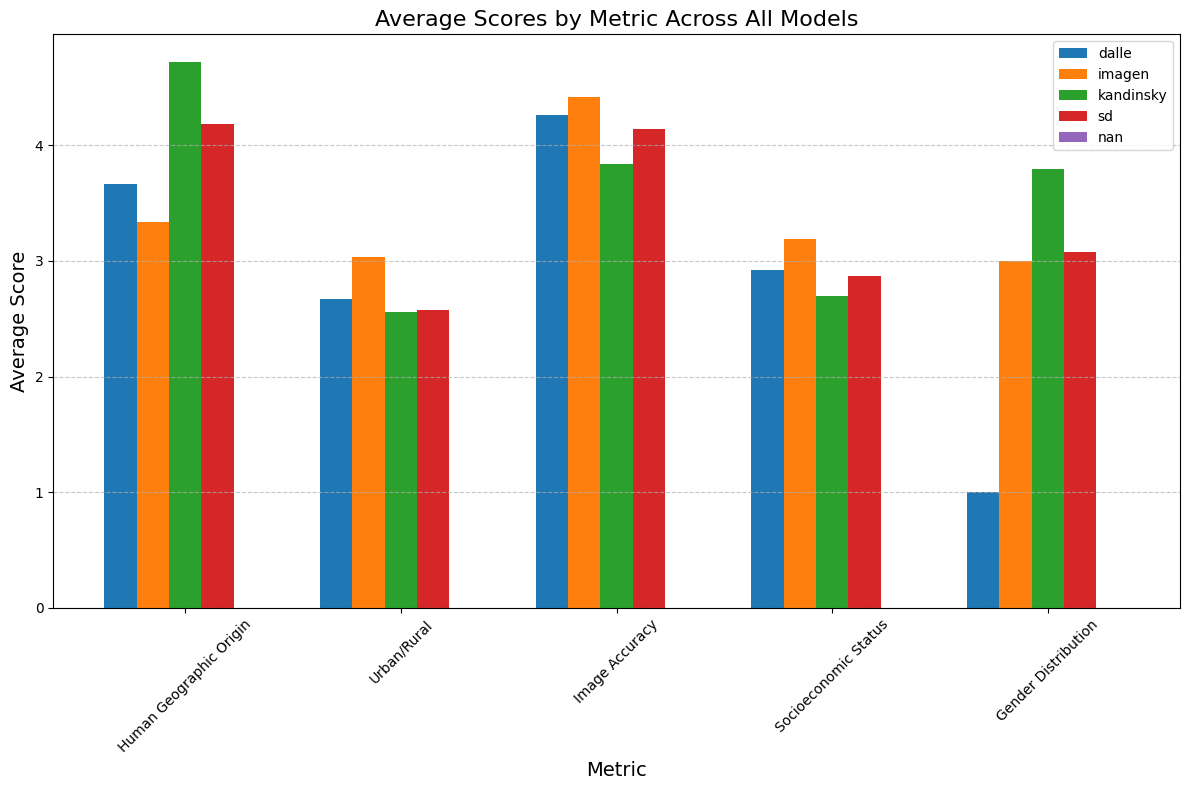

In [24]:

cum_df = pd.read_csv('cum_df.csv')

restracker = {}
for model in cum_df['model'].unique():
    model_df = cum_df[cum_df['model'] == model]
    restracker[model] = {}

    for numR in numeric_cols:
        nonzero = model_df[model_df[numR] != 0]
        if len(nonzero) > 0:
            avg = nonzero[numR].mean()
            # print(f"{model} {numR}: {avg}")
        else:
            # print(f"{model} {numR}: 0")
            avg = 0

        restracker[model][numR] = avg

# Create a DataFrame from the restracker dictionary for easier plotting
model_metrics_df = pd.DataFrame.from_dict(restracker, orient='index')

# Remove NaN values
model_metrics_df = model_metrics_df.fillna(0)
# Create a single plot with metrics on x-axis and models as bars
plt.figure(figsize=(12, 8))

# Set width of bars
bar_width = 0.15
index = np.arange(len(numeric_cols))

# Plot bars for each model side by side
for i, model in enumerate(model_metrics_df.index):
    plt.bar(index + i * bar_width, 
            model_metrics_df.loc[model, numeric_cols], 
            bar_width,
            label=model)

# Customize the chart
plt.title('Average Scores by Metric Across All Models', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(index + bar_width * (len(model_metrics_df.index) - 1) / 2, numeric_cols, rotation=45)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


